# Import Dependencies

In [1]:
# Import relevant libraries
from splinter import Browser
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd
import numpy as np
import requests

browser = Browser('chrome')

# Iterating through Numbers pages to store all the data

In [2]:
numbers_url = "https://www.the-numbers.com/movie/budgets/all"
browser.visit(numbers_url)

# Create empty lists for rows
headers = []
data_rows = []

# Create the full list of page clicks
all_page_clicks=[]
all_page_numbers = np.arange(101, 6501, 100)
for page in all_page_numbers:
    if page < 1000:
        all_page_clicks.append(str(page)+"-")
    elif page < 10000:
        if page%1000 == 1:
            all_page_clicks.append(str(page//1000)+",001-")
        else:
            all_page_clicks.append(str(page//1000)+","+str(page%1000))

for i in range(len(all_page_numbers)+1):
    # Scrape the website
    html = browser.html
    # Create a Beautiful Soup object
    soup = BeautifulSoup(html, "html.parser")
    # Extract all rows
    all_rows = soup.find_all("tr")
    
    # Loop through the scraped data to create a list of headers for first iteration only
    if i == 0:
        header_scrape = all_rows[0].find_all("th")
        for header in header_scrape:
            headers.append(header.text)

    # Loop through the scraped data to create a list of data rows
    for row in all_rows[1:]:
        data = []
        for r in row.find_all("td"):
            data.append(r.text)
        data_rows.append(data)
    if i < len(all_page_numbers):
        if i%5 == 0:
            print("clicking " + all_page_clicks[i])
        browser.links.find_by_partial_text(all_page_clicks[i]).click()

clicking 101-
clicking 601-
clicking 1,101
clicking 1,601
clicking 2,101
clicking 2,601
clicking 3,101
clicking 3,601
clicking 4,101
clicking 4,601
clicking 5,101
clicking 5,601
clicking 6,101


In [3]:
# Create a Pandas DataFrame by using the list of rows and a list of the column names
movies_df = pd.DataFrame(data_rows, columns=headers)
movies_df

,,ReleaseDate,Movie,ProductionBudget,DomesticGross,WorldwideGross
0,1,"Dec 9, 2022",Avatar: The Way of Water,"$460,000,000","$684,075,767","$2,319,591,720"
1,2,"Apr 23, 2019",Avengers: Endgame,"$400,000,000","$858,373,000","$2,788,912,285"
2,3,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$379,000,000","$241,071,802","$1,045,713,802"
3,4,"Apr 22, 2015",Avengers: Age of Ultron,"$365,000,000","$459,005,868","$1,395,316,979"
4,5,"May 17, 2023",Fast X,"$340,000,000","$145,960,660","$714,414,576"
...,...,...,...,...,...,...
6435,"6,436","Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
6436,"6,437","Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
6437,"6,438","Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0
6438,"6,439","Aug 5, 2005",My Date With Drew,"$1,100","$181,041","$181,041"


In [4]:
# Drop the website's index column
movies_df = movies_df[['ReleaseDate', 'Movie', 'ProductionBudget', 'DomesticGross', 'WorldwideGross']]
movies_df.head()

,ReleaseDate,Movie,ProductionBudget,DomesticGross,WorldwideGross
0,"Dec 9, 2022",Avatar: The Way of Water,"$460,000,000","$684,075,767","$2,319,591,720"
1,"Apr 23, 2019",Avengers: Endgame,"$400,000,000","$858,373,000","$2,788,912,285"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$379,000,000","$241,071,802","$1,045,713,802"
3,"Apr 22, 2015",Avengers: Age of Ultron,"$365,000,000","$459,005,868","$1,395,316,979"
4,"May 17, 2023",Fast X,"$340,000,000","$145,960,660","$714,414,576"


# Pull the OMDBAPI Data

**NOTE THIS QUERY TAKES A WHILE TO COMPLETE**

Leverages the movie list from the Numbers scrape

In [6]:
# Chris' OMDB API key (250k a day = 1 data pull a day)
# api_key = 'ac6cb27f'
# Bekah's OMDB API key (250k a day = 1 data pull a day)
api_key = '2ec19c8d'

# Base URL for OMDB API
omdb_url = 'http://www.omdbapi.com/'

# Do query with type = movie restriction to try and avoid mapping to series with the same name
def get_movie_details(title):
    params = {'apikey': api_key, 't': title, 'type':'movie'}
    response = requests.get(omdb_url, params=params)
    data = response.json()
    return data

# Define a list of fields you want to extract from the API response
fields_to_extract = ['Title', 'Rated', 'Released', 'Runtime', 'Genre', 'Director', 
                     'Writer', 'Actors', 'Language', 'Country', 'Type', 'Metascore', 
                     'imdbRating', 'imdbVotes', 'BoxOffice', 'Production']

In [7]:
# Iterate through each row in the DataFrame and append selected fields from the API response
for index, row in movies_df.iterrows():
    movie_title = row['Movie']
    movie_details = get_movie_details(movie_title)

    # Append selected fields to the DataFrame
    for field in fields_to_extract:
        column_name = f'OMDB_{field}'
        movies_df.at[index, column_name] = movie_details.get(field, '')

movies_df

,ReleaseDate,Movie,ProductionBudget,DomesticGross,WorldwideGross,OMDB_Title,OMDB_Rated,OMDB_Released,OMDB_Runtime,OMDB_Genre,...,OMDB_Writer,OMDB_Actors,OMDB_Language,OMDB_Country,OMDB_Type,OMDB_Metascore,OMDB_imdbRating,OMDB_imdbVotes,OMDB_BoxOffice,OMDB_Production
0,"Dec 9, 2022",Avatar: The Way of Water,"$460,000,000","$684,075,767","$2,319,591,720",Avatar: The Way of Water,PG-13,16 Dec 2022,192 min,"Action, Adventure, Fantasy",...,"James Cameron, Rick Jaffa, Amanda Silver","Sam Worthington, Zoe Saldana, Sigourney Weaver",English,United States,movie,67,7.6,"466,460","$684,075,767",N/A
1,"Apr 23, 2019",Avengers: Endgame,"$400,000,000","$858,373,000","$2,788,912,285",Avengers: Endgame,PG-13,26 Apr 2019,181 min,"Action, Adventure, Drama",...,"Christopher Markus, Stephen McFeely, Stan Lee","Robert Downey Jr., Chris Evans, Mark Ruffalo","English, Japanese, Xhosa, German",United States,movie,78,8.4,"1,223,491","$858,373,000",N/A
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$379,000,000","$241,071,802","$1,045,713,802",Pirates of the Caribbean: On Stranger Tides,PG-13,20 May 2011,136 min,"Action, Adventure, Fantasy",...,"Ted Elliott, Terry Rossio, Stuart Beattie","Johnny Depp, Penélope Cruz, Ian McShane","English, Spanish","United States, United Kingdom",movie,45,6.6,"552,123","$241,071,802",N/A
3,"Apr 22, 2015",Avengers: Age of Ultron,"$365,000,000","$459,005,868","$1,395,316,979",Avengers: Age of Ultron,PG-13,01 May 2015,141 min,"Action, Adventure, Sci-Fi",...,"Joss Whedon, Stan Lee, Jack Kirby","Robert Downey Jr., Chris Evans, Mark Ruffalo","English, Korean",United States,movie,66,7.3,"902,827","$459,005,868",N/A
4,"May 17, 2023",Fast X,"$340,000,000","$145,960,660","$714,414,576",Fast X,PG-13,19 May 2023,141 min,"Action, Adventure, Crime",...,"Dan Mazeau, Justin Lin, Zach Dean","Vin Diesel, Michelle Rodriguez, Jason Statham",English,"United States, China, Japan",movie,56,5.8,"101,452","$145,960,660",N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6435,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495",Following,R,05 Nov 1999,69 min,"Crime, Mystery, Thriller",...,Christopher Nolan,"Jeremy Theobald, Alex Haw, Lucy Russell",English,United Kingdom,movie,60,7.5,"99,294","$48,482",N/A
6436,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338",Return to the Land of Wonders,N/A,27 Apr 2004,88 min,"Documentary, War",...,N/A,N/A,"Arabic, English","United States, Germany, United Kingdom",movie,60,6.9,44,"$1,338",N/A
6437,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0,A Plague So Pleasant,N/A,26 Jan 2013,76 min,"Drama, Horror, Thriller",...,Benjamin Roberds,"Eva Boehnke, David Chandler, Maxwell Moody",English,United States,movie,N/A,5.7,80,N/A,N/A
6438,"Aug 5, 2005",My Date With Drew,"$1,100","$181,041","$181,041",My Date with Drew,PG,30 Sep 2005,90 min,Documentary,...,N/A,"Brian Herzlinger, Drew Barrymore, John August",English,United States,movie,51,6.5,"4,699","$181,041",N/A


In [8]:
# Some movies and shows have the same title. 
# The OMDB search may return non-movies or not have a title match so we remove the rows that are not "movie".
movies_df = movies_df[movies_df['OMDB_Type'] == 'movie']
# Remove the type column from the dataframe
movies_df = movies_df.drop(['OMDB_Type'], axis=1)
print(f'Number of movies in dataset: {len(movies_df)}')
movies_df.head()

Number of movies in dataset: 6047


,ReleaseDate,Movie,ProductionBudget,DomesticGross,WorldwideGross,OMDB_Title,OMDB_Rated,OMDB_Released,OMDB_Runtime,OMDB_Genre,OMDB_Director,OMDB_Writer,OMDB_Actors,OMDB_Language,OMDB_Country,OMDB_Metascore,OMDB_imdbRating,OMDB_imdbVotes,OMDB_BoxOffice,OMDB_Production
0,"Dec 9, 2022",Avatar: The Way of Water,"$460,000,000","$684,075,767","$2,319,591,720",Avatar: The Way of Water,PG-13,16 Dec 2022,192 min,"Action, Adventure, Fantasy",James Cameron,"James Cameron, Rick Jaffa, Amanda Silver","Sam Worthington, Zoe Saldana, Sigourney Weaver",English,United States,67,7.6,"466,460","$684,075,767",N/A
1,"Apr 23, 2019",Avengers: Endgame,"$400,000,000","$858,373,000","$2,788,912,285",Avengers: Endgame,PG-13,26 Apr 2019,181 min,"Action, Adventure, Drama","Anthony Russo, Joe Russo","Christopher Markus, Stephen McFeely, Stan Lee","Robert Downey Jr., Chris Evans, Mark Ruffalo","English, Japanese, Xhosa, German",United States,78,8.4,"1,223,491","$858,373,000",N/A
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$379,000,000","$241,071,802","$1,045,713,802",Pirates of the Caribbean: On Stranger Tides,PG-13,20 May 2011,136 min,"Action, Adventure, Fantasy",Rob Marshall,"Ted Elliott, Terry Rossio, Stuart Beattie","Johnny Depp, Penélope Cruz, Ian McShane","English, Spanish","United States, United Kingdom",45,6.6,"552,123","$241,071,802",N/A
3,"Apr 22, 2015",Avengers: Age of Ultron,"$365,000,000","$459,005,868","$1,395,316,979",Avengers: Age of Ultron,PG-13,01 May 2015,141 min,"Action, Adventure, Sci-Fi",Joss Whedon,"Joss Whedon, Stan Lee, Jack Kirby","Robert Downey Jr., Chris Evans, Mark Ruffalo","English, Korean",United States,66,7.3,"902,827","$459,005,868",N/A
4,"May 17, 2023",Fast X,"$340,000,000","$145,960,660","$714,414,576",Fast X,PG-13,19 May 2023,141 min,"Action, Adventure, Crime",Louis Leterrier,"Dan Mazeau, Justin Lin, Zach Dean","Vin Diesel, Michelle Rodriguez, Jason Statham",English,"United States, China, Japan",56,5.8,"101,452","$145,960,660",N/A


In [9]:
movies_df.to_csv("./Resources/movies_raw.csv")

# Format column data types from objects to numbers

In [24]:
#  # Import and read the data if you screwed up :)
# movies_df = pd.read_csv("./Resources/movies_raw.csv")
# movies_df = movies_df[['ReleaseDate', 'Movie', 'ProductionBudget', 'DomesticGross', 'WorldwideGross', 
#                         'OMDB_Title', 'OMDB_Rated','OMDB_Released', 'OMDB_Runtime', 'OMDB_Genre', 'OMDB_Director',
#                         'OMDB_Writer', 'OMDB_Actors', 'OMDB_Language', 'OMDB_Country', 'OMDB_Metascore', 
#                         'OMDB_imdbRating', 'OMDB_imdbVotes', 'OMDB_BoxOffice', 'OMDB_Production']]
# movies_df.head()

,ReleaseDate,Movie,ProductionBudget,DomesticGross,WorldwideGross,OMDB_Title,OMDB_Rated,OMDB_Released,OMDB_Runtime,OMDB_Genre,OMDB_Director,OMDB_Writer,OMDB_Actors,OMDB_Language,OMDB_Country,OMDB_Metascore,OMDB_imdbRating,OMDB_imdbVotes,OMDB_BoxOffice,OMDB_Production
0,"Dec 9, 2022",Avatar: The Way of Water,"$460,000,000","$684,075,767","$2,319,591,720",Avatar: The Way of Water,PG-13,16 Dec 2022,192 min,"Action, Adventure, Fantasy",James Cameron,"James Cameron, Rick Jaffa, Amanda Silver","Sam Worthington, Zoe Saldana, Sigourney Weaver",English,United States,67.0,7.6,"466,460","$684,075,767",NaN
1,"Apr 23, 2019",Avengers: Endgame,"$400,000,000","$858,373,000","$2,788,912,285",Avengers: Endgame,PG-13,26 Apr 2019,181 min,"Action, Adventure, Drama","Anthony Russo, Joe Russo","Christopher Markus, Stephen McFeely, Stan Lee","Robert Downey Jr., Chris Evans, Mark Ruffalo","English, Japanese, Xhosa, German",United States,78.0,8.4,"1,223,491","$858,373,000",NaN
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$379,000,000","$241,071,802","$1,045,713,802",Pirates of the Caribbean: On Stranger Tides,PG-13,20 May 2011,136 min,"Action, Adventure, Fantasy",Rob Marshall,"Ted Elliott, Terry Rossio, Stuart Beattie","Johnny Depp, Penélope Cruz, Ian McShane","English, Spanish","United States, United Kingdom",45.0,6.6,"552,123","$241,071,802",NaN
3,"Apr 22, 2015",Avengers: Age of Ultron,"$365,000,000","$459,005,868","$1,395,316,979",Avengers: Age of Ultron,PG-13,01 May 2015,141 min,"Action, Adventure, Sci-Fi",Joss Whedon,"Joss Whedon, Stan Lee, Jack Kirby","Robert Downey Jr., Chris Evans, Mark Ruffalo","English, Korean",United States,66.0,7.3,"902,827","$459,005,868",NaN
4,"May 17, 2023",Fast X,"$340,000,000","$145,960,660","$714,414,576",Fast X,PG-13,19 May 2023,141 min,"Action, Adventure, Crime",Louis Leterrier,"Dan Mazeau, Justin Lin, Zach Dean","Vin Diesel, Michelle Rodriguez, Jason Statham",English,"United States, China, Japan",56.0,5.8,"101,452","$145,960,660",NaN


In [25]:
# Examine data type of each column
movies_df.dtypes

ReleaseDate          object
Movie                object
ProductionBudget     object
DomesticGross        object
WorldwideGross       object
OMDB_Title           object
OMDB_Rated           object
OMDB_Released        object
OMDB_Runtime         object
OMDB_Genre           object
OMDB_Director        object
OMDB_Writer          object
OMDB_Actors          object
OMDB_Language        object
OMDB_Country         object
OMDB_Metascore      float64
OMDB_imdbRating     float64
OMDB_imdbVotes       object
OMDB_BoxOffice       object
OMDB_Production      object
dtype: object

In [26]:
# delate all "N/A"
movies_df = movies_df.replace('N/A', '')

# Convert $ objests to floats
movies_df[['ProductionBudget','DomesticGross', 'WorldwideGross', 
           'OMDB_BoxOffice']] = movies_df[['ProductionBudget','DomesticGross',
                                           'WorldwideGross', 'OMDB_BoxOffice']].replace('[\$,\s]', '', regex=True)
movies_df[['ProductionBudget','DomesticGross', 'WorldwideGross', 
           'OMDB_BoxOffice']] = movies_df[['ProductionBudget','DomesticGross', 'WorldwideGross', 
                                           'OMDB_BoxOffice']].apply(pd.to_numeric, errors='coerce')

# # Convert number strings with comma to float
movies_df[['OMDB_imdbVotes']] = movies_df[['OMDB_imdbVotes']].replace('[,\s]', '', regex=True)
movies_df['OMDB_imdbVotes'] = pd.to_numeric(movies_df['OMDB_imdbVotes'], errors='coerce')

# # Convert runtime to float after removing " min"
movies_df[['OMDB_Runtime']] = movies_df[['OMDB_Runtime']].replace('[min\s]', '', regex=True)
movies_df['OMDB_Runtime'] = pd.to_numeric(movies_df['OMDB_Runtime'], errors='coerce')

# Change date to datetime type (Note "ReleaseDate" has inconsistent formatting / typos)
movies_df["OMDB_Released"] = pd.to_datetime(movies_df["OMDB_Released"])

movies_df.dtypes

ReleaseDate                 object
Movie                       object
ProductionBudget             int64
DomesticGross                int64
WorldwideGross               int64
OMDB_Title                  object
OMDB_Rated                  object
OMDB_Released       datetime64[ns]
OMDB_Runtime               float64
OMDB_Genre                  object
OMDB_Director               object
OMDB_Writer                 object
OMDB_Actors                 object
OMDB_Language               object
OMDB_Country                object
OMDB_Metascore             float64
OMDB_imdbRating            float64
OMDB_imdbVotes             float64
OMDB_BoxOffice             float64
OMDB_Production             object
dtype: object

In [27]:
movies_df.to_csv("./Resources/movies_formatted.csv")

# Minor Processing

## Convert dates into year and month columns removing date columns

In [28]:
#  Import and read the data if you screwed up :)
movies_df = pd.read_csv("./Resources/movies_formatted.csv")
movies_df = movies_df[['ReleaseDate', 'Movie', 'ProductionBudget', 'DomesticGross', 'WorldwideGross', 
                        'OMDB_Title', 'OMDB_Rated','OMDB_Released', 'OMDB_Runtime', 'OMDB_Genre', 'OMDB_Director',
                        'OMDB_Writer', 'OMDB_Actors', 'OMDB_Language', 'OMDB_Country', 'OMDB_Metascore', 
                        'OMDB_imdbRating', 'OMDB_imdbVotes', 'OMDB_BoxOffice', 'OMDB_Production']]
# Change date to datetime type (Note "ReleaseDate" has inconsistent formatting / typos)
movies_df["OMDB_Released"] = pd.to_datetime(movies_df["OMDB_Released"])
movies_df

,ReleaseDate,Movie,ProductionBudget,DomesticGross,WorldwideGross,OMDB_Title,OMDB_Rated,OMDB_Released,OMDB_Runtime,OMDB_Genre,OMDB_Director,OMDB_Writer,OMDB_Actors,OMDB_Language,OMDB_Country,OMDB_Metascore,OMDB_imdbRating,OMDB_imdbVotes,OMDB_BoxOffice,OMDB_Production
0,"Dec 9, 2022",Avatar: The Way of Water,460000000,684075767,2319591720,Avatar: The Way of Water,PG-13,2022-12-16,192.0,"Action, Adventure, Fantasy",James Cameron,"James Cameron, Rick Jaffa, Amanda Silver","Sam Worthington, Zoe Saldana, Sigourney Weaver",English,United States,67.0,7.6,466460.0,684075767.0,NaN
1,"Apr 23, 2019",Avengers: Endgame,400000000,858373000,2788912285,Avengers: Endgame,PG-13,2019-04-26,181.0,"Action, Adventure, Drama","Anthony Russo, Joe Russo","Christopher Markus, Stephen McFeely, Stan Lee","Robert Downey Jr., Chris Evans, Mark Ruffalo","English, Japanese, Xhosa, German",United States,78.0,8.4,1223491.0,858373000.0,NaN
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,379000000,241071802,1045713802,Pirates of the Caribbean: On Stranger Tides,PG-13,2011-05-20,136.0,"Action, Adventure, Fantasy",Rob Marshall,"Ted Elliott, Terry Rossio, Stuart Beattie","Johnny Depp, Penélope Cruz, Ian McShane","English, Spanish","United States, United Kingdom",45.0,6.6,552123.0,241071802.0,NaN
3,"Apr 22, 2015",Avengers: Age of Ultron,365000000,459005868,1395316979,Avengers: Age of Ultron,PG-13,2015-05-01,141.0,"Action, Adventure, Sci-Fi",Joss Whedon,"Joss Whedon, Stan Lee, Jack Kirby","Robert Downey Jr., Chris Evans, Mark Ruffalo","English, Korean",United States,66.0,7.3,902827.0,459005868.0,NaN
4,"May 17, 2023",Fast X,340000000,145960660,714414576,Fast X,PG-13,2023-05-19,141.0,"Action, Adventure, Crime",Louis Leterrier,"Dan Mazeau, Justin Lin, Zach Dean","Vin Diesel, Michelle Rodriguez, Jason Statham",English,"United States, China, Japan",56.0,5.8,101452.0,145960660.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6042,"Apr 2, 1999",Following,6000,48482,240495,Following,R,1999-11-05,69.0,"Crime, Mystery, Thriller",Christopher Nolan,Christopher Nolan,"Jeremy Theobald, Alex Haw, Lucy Russell",English,United Kingdom,60.0,7.5,99294.0,48482.0,NaN
6043,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,Return to the Land of Wonders,NaN,2004-04-27,88.0,"Documentary, War",Maysoon Pachachi,NaN,NaN,"Arabic, English","United States, Germany, United Kingdom",60.0,6.9,44.0,1338.0,NaN
6044,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,A Plague So Pleasant,NaN,2013-01-26,76.0,"Drama, Horror, Thriller","Benjamin Roberds, Jordan Reyes",Benjamin Roberds,"Eva Boehnke, David Chandler, Maxwell Moody",English,United States,NaN,5.7,80.0,NaN,NaN
6045,"Aug 5, 2005",My Date With Drew,1100,181041,181041,My Date with Drew,PG,2005-09-30,90.0,Documentary,"Jon Gunn, Brian Herzlinger, Brett Winn",NaN,"Brian Herzlinger, Drew Barrymore, John August",English,United States,51.0,6.5,4699.0,181041.0,NaN


In [29]:
movies_df.dtypes

ReleaseDate                 object
Movie                       object
ProductionBudget             int64
DomesticGross                int64
WorldwideGross               int64
OMDB_Title                  object
OMDB_Rated                  object
OMDB_Released       datetime64[ns]
OMDB_Runtime               float64
OMDB_Genre                  object
OMDB_Director               object
OMDB_Writer                 object
OMDB_Actors                 object
OMDB_Language               object
OMDB_Country                object
OMDB_Metascore             float64
OMDB_imdbRating            float64
OMDB_imdbVotes             float64
OMDB_BoxOffice             float64
OMDB_Production             object
dtype: object

In [30]:
movies_df["ReleaseYear"] = pd.DatetimeIndex(movies_df['OMDB_Released']).year
movies_df["ReleaseMonth"] = pd.DatetimeIndex(movies_df['OMDB_Released']).month
movies_df = movies_df.drop(['ReleaseDate', 'OMDB_Released'], axis=1)
movies_df.head()

,Movie,ProductionBudget,DomesticGross,WorldwideGross,OMDB_Title,OMDB_Rated,OMDB_Runtime,OMDB_Genre,OMDB_Director,OMDB_Writer,OMDB_Actors,OMDB_Language,OMDB_Country,OMDB_Metascore,OMDB_imdbRating,OMDB_imdbVotes,OMDB_BoxOffice,OMDB_Production,ReleaseYear,ReleaseMonth
0,Avatar: The Way of Water,460000000,684075767,2319591720,Avatar: The Way of Water,PG-13,192.0,"Action, Adventure, Fantasy",James Cameron,"James Cameron, Rick Jaffa, Amanda Silver","Sam Worthington, Zoe Saldana, Sigourney Weaver",English,United States,67.0,7.6,466460.0,684075767.0,NaN,2022.0,12.0
1,Avengers: Endgame,400000000,858373000,2788912285,Avengers: Endgame,PG-13,181.0,"Action, Adventure, Drama","Anthony Russo, Joe Russo","Christopher Markus, Stephen McFeely, Stan Lee","Robert Downey Jr., Chris Evans, Mark Ruffalo","English, Japanese, Xhosa, German",United States,78.0,8.4,1223491.0,858373000.0,NaN,2019.0,4.0
2,Pirates of the Caribbean: On Stranger Tides,379000000,241071802,1045713802,Pirates of the Caribbean: On Stranger Tides,PG-13,136.0,"Action, Adventure, Fantasy",Rob Marshall,"Ted Elliott, Terry Rossio, Stuart Beattie","Johnny Depp, Penélope Cruz, Ian McShane","English, Spanish","United States, United Kingdom",45.0,6.6,552123.0,241071802.0,NaN,2011.0,5.0
3,Avengers: Age of Ultron,365000000,459005868,1395316979,Avengers: Age of Ultron,PG-13,141.0,"Action, Adventure, Sci-Fi",Joss Whedon,"Joss Whedon, Stan Lee, Jack Kirby","Robert Downey Jr., Chris Evans, Mark Ruffalo","English, Korean",United States,66.0,7.3,902827.0,459005868.0,NaN,2015.0,5.0
4,Fast X,340000000,145960660,714414576,Fast X,PG-13,141.0,"Action, Adventure, Crime",Louis Leterrier,"Dan Mazeau, Justin Lin, Zach Dean","Vin Diesel, Michelle Rodriguez, Jason Statham",English,"United States, China, Japan",56.0,5.8,101452.0,145960660.0,NaN,2023.0,5.0


In [31]:
movies_df.columns

Index(['Movie', 'ProductionBudget', 'DomesticGross', 'WorldwideGross',
       'OMDB_Title', 'OMDB_Rated', 'OMDB_Runtime', 'OMDB_Genre',
       'OMDB_Director', 'OMDB_Writer', 'OMDB_Actors', 'OMDB_Language',
       'OMDB_Country', 'OMDB_Metascore', 'OMDB_imdbRating', 'OMDB_imdbVotes',
       'OMDB_BoxOffice', 'OMDB_Production', 'ReleaseYear', 'ReleaseMonth'],
      dtype='object')

# Investigate Inputs / Features: should any be consolidated or truncated

Inputs / Features = ['Movie', 'ProductionBudget',  'OMDB_Title', 'OMDB_Rated', 'OMDB_Runtime', 'OMDB_Genre', 'OMDB_Director', 'OMDB_Writer', 'OMDB_Actors', 'OMDB_Language', 'OMDB_Country',  'OMDB_Production', 'ReleaseYear', 'ReleaseMonth']

In [32]:
# Look at Rated values to see if consolidation would be beneficial
movies_df['OMDB_Rated'].value_counts()

R            2511
PG-13        1794
PG            841
Not Rated     326
G             144
Approved       44
Unrated        39
Passed         36
TV-MA          34
TV-PG          12
TV-14           9
NC-17           9
TV-G            5
X               4
GP              3
M/PG            3
16+             2
18+             2
M               2
13+             1
Name: OMDB_Rated, dtype: int64

In [33]:
# Define Consolidate Rated Lists:
# reference https://en.wikipedia.org/wiki/Motion_Picture_Association_film_rating_system
kids = ['PG', 'G', 'TV-PG', 'TV-G', 'GP', 'M/PG', 'M']
teens = ['PG-13', 'TV-14', '16+', '13+']
adults = ['R', 'TV-MA', 'NC-17', 'X', '18+']
Unknown = ['Not Rated', 'Approved', 'Unrated', 'Passed']

for index, row in movies_df.iterrows():
    movie_rating = row['OMDB_Rated']
    if movie_rating in kids:
        movies_df.at[index,'OMDB_Rated'] = 'kids'
    elif movie_rating in teens:
        movies_df.at[index,'OMDB_Rated'] = 'teens'
    elif movie_rating in adults:
        movies_df.at[index,'OMDB_Rated'] = 'adults'
    else:
        movies_df.at[index,'OMDB_Rated'] = 'unknown'

# df["grade"] = df.apply(lambda x: 'A+' if ((x['score']>40)&(x['score']<50)) else x["grade"], axis=1)
# movies_df.OMDB_Rated = np.where((movies_df.OMDB_Rated in kids), 'kids', movies_df.OMDB_Rated)

movies_df['OMDB_Rated'].value_counts()

adults     2560
teens      1806
kids       1010
unknown     671
Name: OMDB_Rated, dtype: int64

In [34]:
# Look at Release Month values to see distribution
movies_df['ReleaseMonth'].value_counts()

10.0    578
11.0    539
8.0     539
3.0     521
12.0    504
6.0     499
7.0     487
4.0     485
9.0     484
1.0     481
2.0     460
5.0     415
Name: ReleaseMonth, dtype: int64

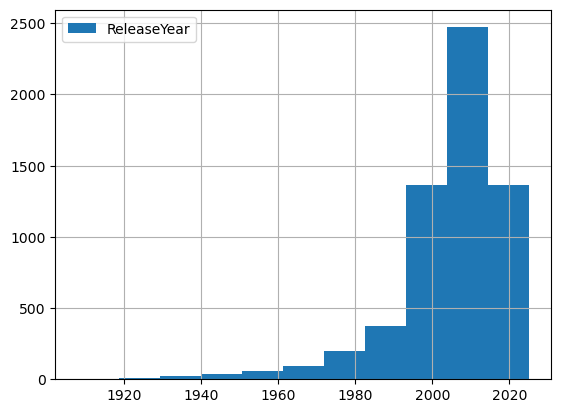

In [35]:
# Look at Release Year values to see if consolidation / removal would be beneficial
year_hist = movies_df['ReleaseYear'].hist(bins=11, legend=True)

Number of movies in dataset: 5668


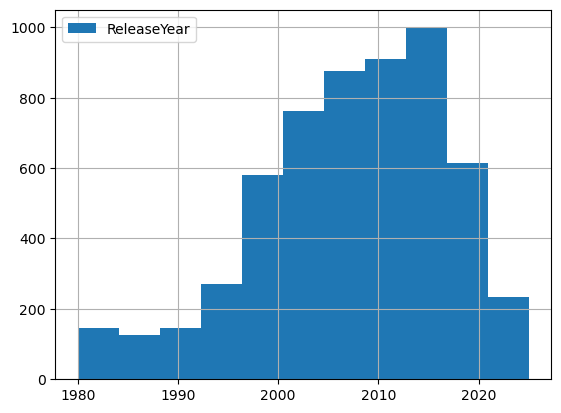

In [36]:
# Drop the earlier movies (low count and significant $ differences)
movies_df = movies_df[movies_df['ReleaseYear'] >= 1980]

print(f'Number of movies in dataset: {len(movies_df)}')
year_hist2 = movies_df['ReleaseYear'].hist(bins=11, legend=True)

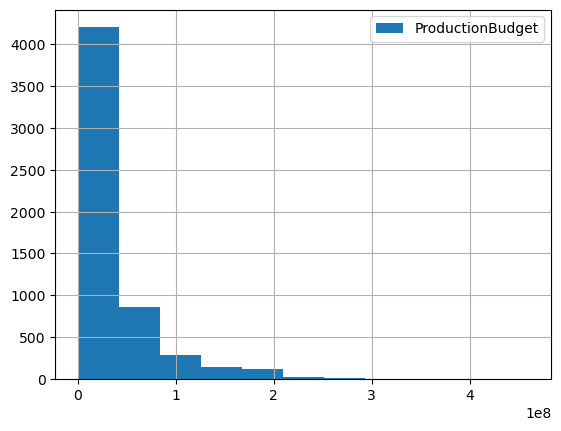

In [37]:
# Look at budget values to see if consolidation would be beneficial
budget_hist = movies_df['ProductionBudget'].hist(bins=11, legend=True)

Number of movies in dataset: 5253


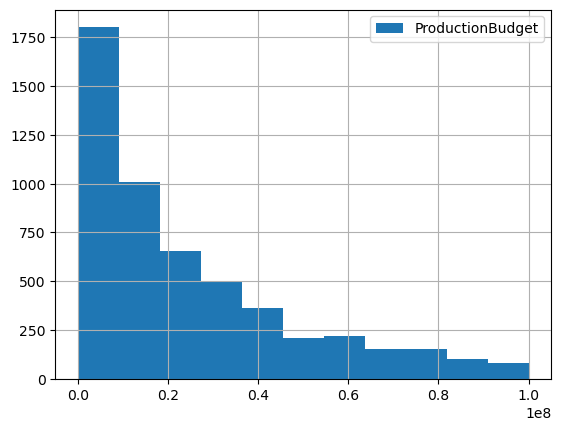

In [38]:
lower_budget_movies_df = movies_df[movies_df['ProductionBudget'] <= 100000000]
print(f'Number of movies in dataset: {len(lower_budget_movies_df)}')
lower_budget_hist = lower_budget_movies_df['ProductionBudget'].hist(bins=11, legend=True)

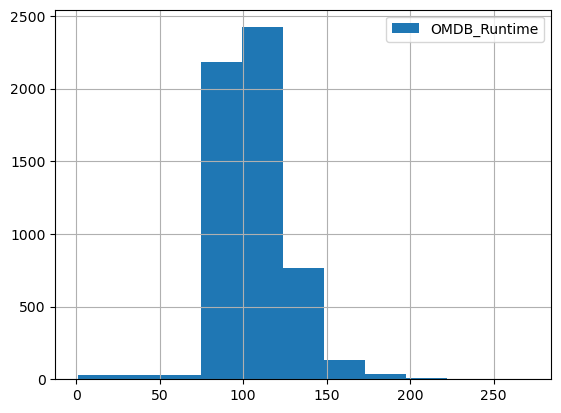

In [39]:
# Look at Runtime values to see if consolidation / removal would be beneficial
year_hist = movies_df['OMDB_Runtime'].hist(bins=11, legend=True)

Number of movies in dataset: 5548


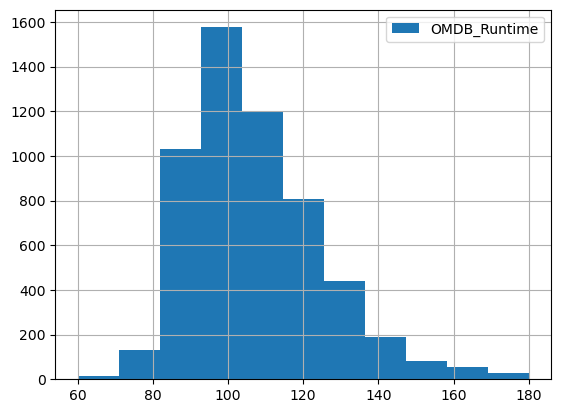

In [40]:
mid_runtime_movies_df = movies_df[(movies_df['OMDB_Runtime'] >= 60) & (movies_df['OMDB_Runtime'] <= 180)]
print(f'Number of movies in dataset: {len(mid_runtime_movies_df)}')
mid_runtime_hist = mid_runtime_movies_df['OMDB_Runtime'].hist(bins=11, legend=True)

In [41]:
# Look at Production values to see what we have
movies_df['OMDB_Production'].value_counts()

Paramount Pictures                                             2
20th Century Fox                                               2
De Line Pictures                                               1
Metro-Goldwyn-Mayer, United Artists                            1
Engine 15 Media Corp                                           1
Live Home Video                                                1
Weston Pictures                                                1
High Five Films                                                1
Phase 4 Films                                                  1
France 2 Cinéma, Mars Film                                     1
Zebra                                                          1
Blumhouse, Mosaic                                              1
Universal Pictures, QC Entertainment, Blumhouse Productions    1
Caviar                                                         1
Green/Renzi                                                    1
2.4.7. Films             

## Notes on feature distributions:
* OMDB_Rated had 20 categories with overlap which have been reduced to 4 categories: kids (G, PG), teens (PG13), adults(NC-17+, R), and unknown
* Release Month is relatively evenly distributed across months
* Release Year indicates a tail of movies pre-1980 which have been truncated (it could be beneficial to modify that cut-off to 1995).
* Budgets have a tail above 100,000,000 with the biggest chunk at <= 20,000,000 (another potential break could be 50,000,000). All have been kept for the minor processing.
* Runtime has most movies between 80 and 150 minutes with tails on both ends. All have been kept for minor processing.
* OMDB_Production has very few values filled
* OMDB_Genre, OMDB_Director, OMDB_Writer, OMDB_Actors, OMDB_Language, OMDB_Country all have lists within the list

# Investigate Outcomes Distributions

Outputs  / Targets = [ 'DomesticGross', 'WorldwideGross',  'OMDB_Metascore', 'OMDB_imdbRating', 'OMDB_imdbVotes', 'OMDB_BoxOffice']

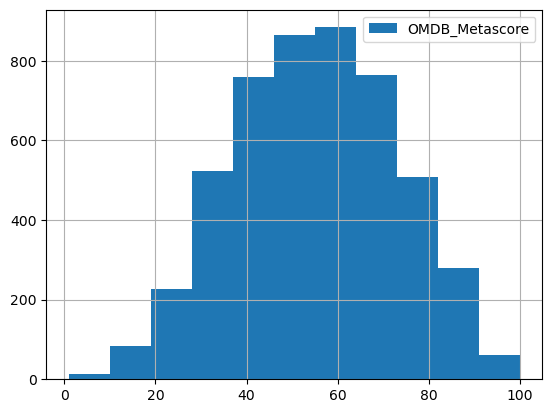

In [42]:
meta_hist = movies_df['OMDB_Metascore'].hist(bins=11, legend=True)

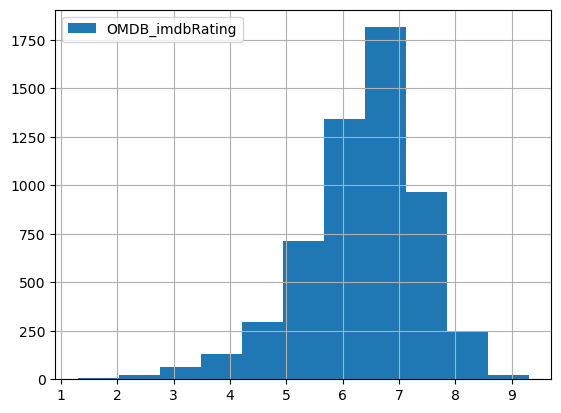

In [43]:
imdb_rating_hist = movies_df['OMDB_imdbRating'].hist(bins=11, legend=True)

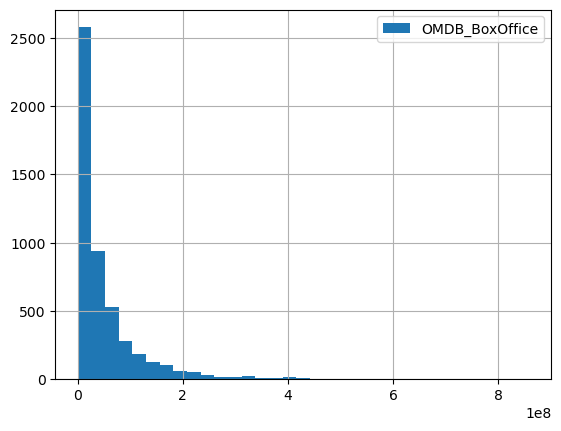

In [44]:
box_office_hist = movies_df['OMDB_BoxOffice'].hist(bins=33, legend=True)

Number of movies in dataset: 4776


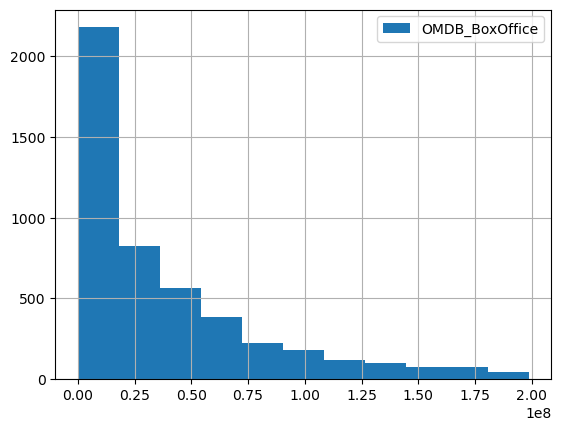

In [45]:
lower_boxoffice_movies_df = movies_df[movies_df['OMDB_BoxOffice'] <= 200000000]
print(f'Number of movies in dataset: {len(lower_boxoffice_movies_df)}')
lower_box_office_hist = lower_boxoffice_movies_df['OMDB_BoxOffice'].hist(bins=11, legend=True)

## Notes on ouput distributions
* OMDB_Metascore has a relatively normal distribution
* OMDB_imbdRating has a relatively normal distribution with a tail on the lower end
* OMDB_BoxOffice has a long tail above 200,000,000; most fall under 100,000,000

# Review potential correlations

Inputs / Features = ['Movie', 'ProductionBudget',  'OMDB_Title', 'OMDB_Rated', 'OMDB_Runtime', 'OMDB_Genre', 'OMDB_Director', 'OMDB_Writer', 'OMDB_Actors', 'OMDB_Language', 'OMDB_Country',  'OMDB_Production', 'ReleaseYear', 'ReleaseMonth']

Outputs  / Targets = [ 'DomesticGross', 'WorldwideGross',  'OMDB_Metascore', 'OMDB_imdbRating', 'OMDB_imdbVotes', 'OMDB_BoxOffice']

## Review outcome to outcome relationships

### Verify assumed Metascore - IMDB Rating relationship

The r-squared is: 0.5442577394218411


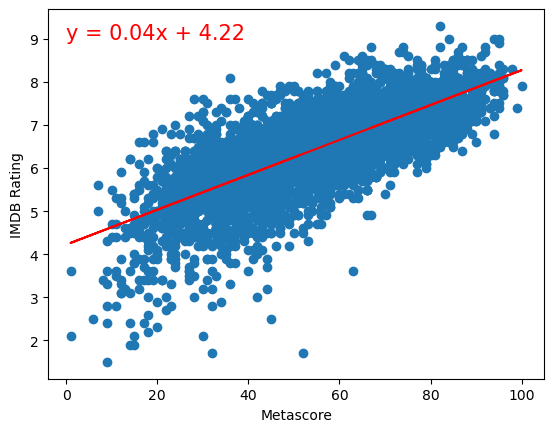

In [46]:
# Define the x and y
movies_df_no_nan = movies_df[['OMDB_Metascore', 'OMDB_imdbRating']]
movies_df_no_nan = movies_df_no_nan.dropna()

x_values = movies_df_no_nan['OMDB_Metascore']
y_values = movies_df_no_nan['OMDB_imdbRating']

# Calculate the regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot the different factors in a scatter plot
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,9),fontsize=15,color="red")
plt.xlabel('Metascore')
plt.ylabel('IMDB Rating')

print(f"The r-squared is: {rvalue**2}")
plt.show()

### Check OMDB_BoxOffice vs. IMDB rating / Metascore

The r-squared is: 0.028356175564871917


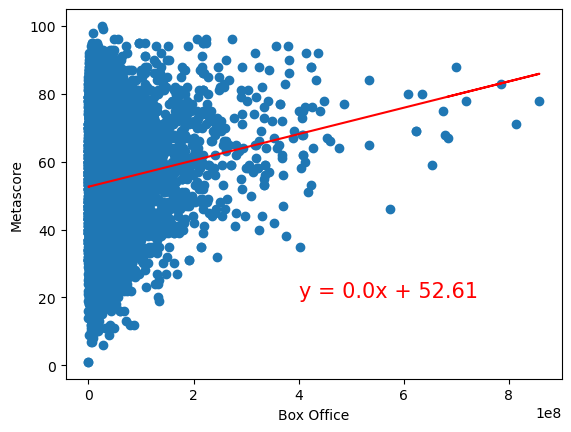

In [50]:
# Define the x and y
movies_df_no_nan = movies_df[['OMDB_BoxOffice', 'OMDB_Metascore']]
movies_df_no_nan = movies_df_no_nan.dropna()

x_values = movies_df_no_nan['OMDB_BoxOffice']
y_values = movies_df_no_nan['OMDB_Metascore']

# Calculate the regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot the different factors in a scatter plot
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(400000000,20),fontsize=15,color="red")
plt.xlabel('Box Office')
plt.ylabel('Metascore')

print(f"The r-squared is: {rvalue**2}")
plt.show()

The r-squared is: 0.05874913853835516


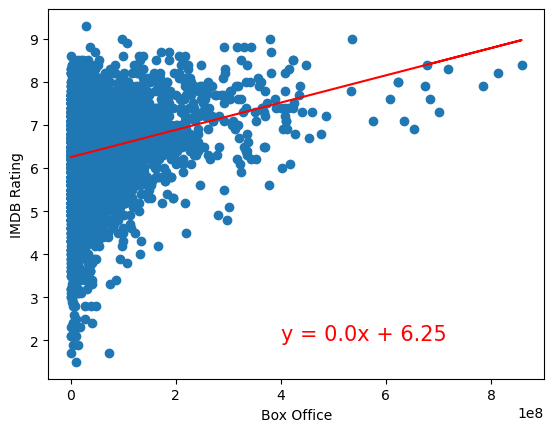

In [52]:
# Define the x and y
movies_df_no_nan = movies_df[['OMDB_BoxOffice', 'OMDB_imdbRating']]
movies_df_no_nan = movies_df_no_nan.dropna()

x_values = movies_df_no_nan['OMDB_BoxOffice']
y_values = movies_df_no_nan['OMDB_imdbRating']

# Calculate the regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot the different factors in a scatter plot
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(400000000,2),fontsize=15,color="red")
plt.xlabel('Box Office')
plt.ylabel('IMDB Rating')

print(f"The r-squared is: {rvalue**2}")
plt.show()

## Review input to outcome relationships

### Check for relationship of production budget vs. IMDB rating / MetaScore / BoxOffice

y = 0.0x + 6.25
The r-squared is: 0.013769715646547605


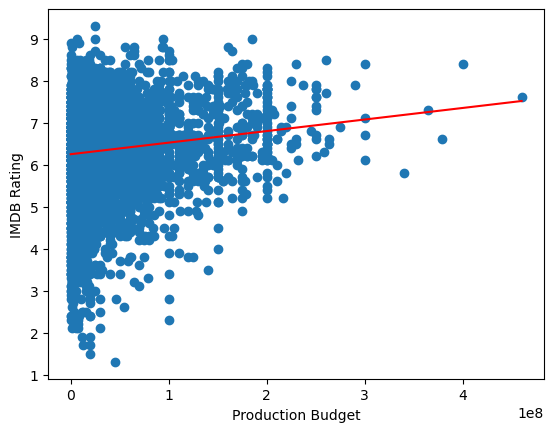

In [53]:
# Plot the different factors in a scatter plot
movies_df_no_nan = movies_df[['ProductionBudget', 'OMDB_imdbRating']]
movies_df_no_nan = movies_df_no_nan.dropna()

x_values = movies_df_no_nan['ProductionBudget']
y_values = movies_df_no_nan['OMDB_imdbRating']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
plt.xlabel('Production Budget')
plt.ylabel('IMDB Rating')

print(line_eq)
print(f"The r-squared is: {rvalue**2}")
plt.show()

y = 0.0x + 54.3
The r-squared is: 0.0001730524389994493


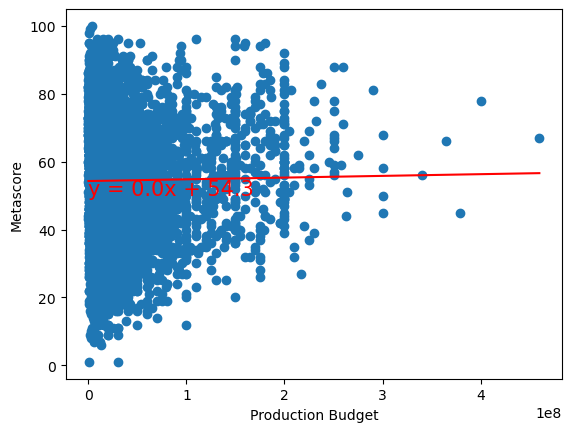

In [54]:
# Plot the different factors in a scatter plot
movies_df_no_nan = movies_df[['ProductionBudget', 'OMDB_Metascore']]
movies_df_no_nan = movies_df_no_nan.dropna()

x_values = movies_df_no_nan['ProductionBudget']
y_values = movies_df_no_nan['OMDB_Metascore']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
plt.xlabel('Production Budget')
plt.ylabel('Metascore')

print(line_eq)
print(f"The r-squared is: {rvalue**2}")
plt.show()

y = 1.1x + 8961110.71
The r-squared is: 0.44561602460817734


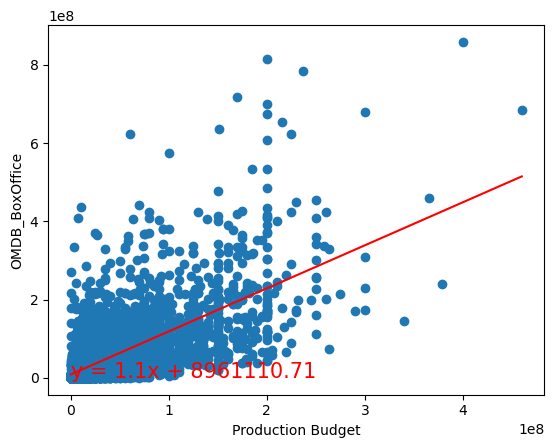

In [55]:
# Plot the different factors in a scatter plot
movies_df_no_nan = movies_df[['ProductionBudget', 'OMDB_BoxOffice']]
movies_df_no_nan = movies_df_no_nan.dropna()

x_values = movies_df_no_nan['ProductionBudget']
y_values = movies_df_no_nan['OMDB_BoxOffice']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
plt.xlabel('Production Budget')
plt.ylabel('OMDB_BoxOffice')

print(line_eq)
print(f"The r-squared is: {rvalue**2}")
plt.show()

### What about trends with release month

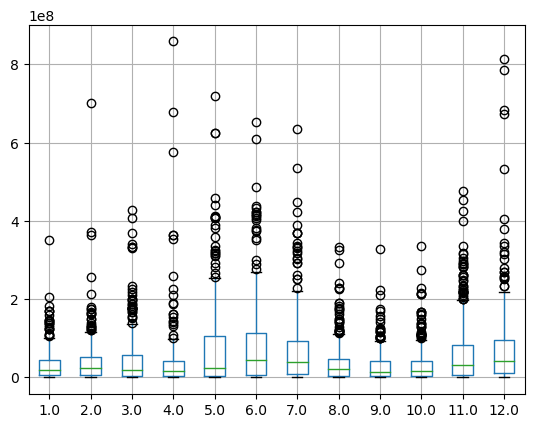

In [65]:
# Create a box plot for each month's BoxOffice
movies_df_no_nan = movies_df[['ReleaseMonth', 'OMDB_BoxOffice']]
movies_df_no_nan = movies_df_no_nan.dropna()

movies_df_no_nan = movies_df_no_nan.pivot_table(index=movies_df_no_nan.index, columns='ReleaseMonth', values='OMDB_BoxOffice')

boxplot = movies_df_no_nan.boxplot()


C:\Users\vt_be\AppData\Local\Temp\ipykernel_28488\1342650851.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lower_movies_df_no_nan = movies_df_no_nan[movies_df['OMDB_BoxOffice'] <= 200000000]


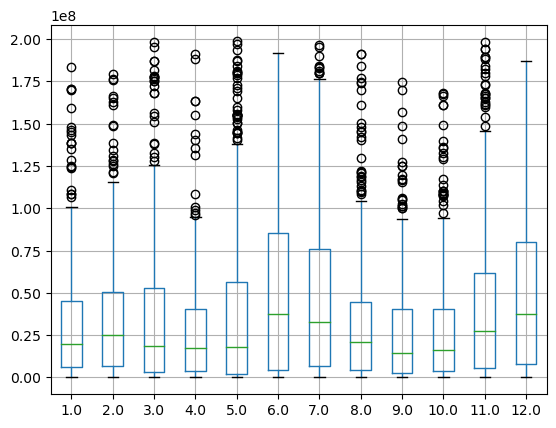

In [69]:
# Create a box plot for each month's BoxOffice for movies with Box Office <=20,0000,000
movies_df_no_nan = movies_df[['ReleaseMonth', 'OMDB_BoxOffice']]
movies_df_no_nan = movies_df_no_nan.dropna()

lower_movies_df_no_nan = movies_df_no_nan[movies_df['OMDB_BoxOffice'] <= 200000000]

lower_movies_df_no_nan = lower_movies_df_no_nan.pivot_table(index=lower_movies_df_no_nan.index, 
                                                            columns='ReleaseMonth', values='OMDB_BoxOffice')

boxplot = lower_movies_df_no_nan.boxplot()

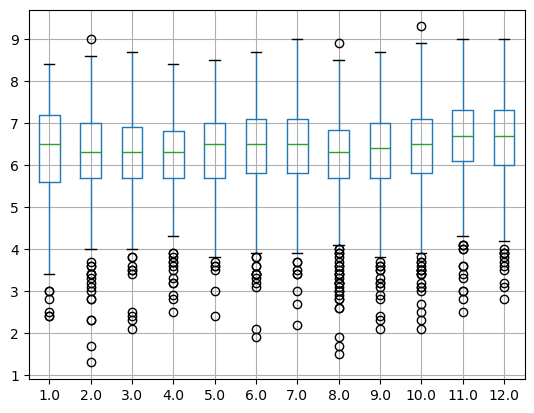

In [70]:
# Create a box plot for each month's BoxOffice
movies_df_no_nan = movies_df[['ReleaseMonth', 'OMDB_imdbRating']]
movies_df_no_nan = movies_df_no_nan.dropna()

movies_df_no_nan = movies_df_no_nan.pivot_table(index=movies_df_no_nan.index, columns='ReleaseMonth', values='OMDB_imdbRating')

boxplot = movies_df_no_nan.boxplot()

## Notes on Ouput Relationships
* Metascore and imdbRating have a mediocre positive relationship
* Box Office does **not** have a meaningful relationship with Metascore nore imdbRating
## Notes on Input to Output Relationships
* Budget does **not** have a meaningful relationship to imdbRating nor Metascore
* Budget does have a minor positve relationship with Box Office
* Box Office box-and-whisker plots by month show quite a few outliers with Box Office above 20,000,000. Removing all movies with Box Office greater than 20,000,000 does show June, July, and December with the best Box Office return
* imdbRating box-and-whisker plots by month do not show much variation across months

In [71]:
movies_df.to_csv("./Resources/movies_processed.csv")

# Summary Findings to Kick-Off Machine Learning Experiments

* Single numeric feature relationships to the IMDB Rating outcome are very weak indicating challenges to using numeric only features to predict viewer ratings.
* Using a critic rating (e.g., Metascore) available to a release can help improve predicting viewer ratings (e.g., IMDB Rating).
* Budget has a minor positive relationship with Box Office but not with IMDB Rating so it could be helpful in predicting Box Office.
* Release month seems to have little impact on IMDB Rating but could be a useful factor in predicting Box Office.
